## Capstone Two - DC Housing Prices Predicting: Modeling

### 1 Import Required Libraries for Regression Modeling and Evaluation

In [3]:
# 1.1 Import required libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### 2 Dataset Loading, Initial Cleaning, and Feature Selection with Encoding

In [5]:
# 2.1 Load dataset
df = pd.read_csv('DC_Properties.csv', low_memory=False)
cols_to_drop = ['Unnamed: 0', 'SOURCE', 'CMPLX_NUM', 'GIS_LAST_MOD_DTTM',
                'SQUARE', 'X', 'Y', 'NATIONALGRID']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df = df[df['PRICE'] > 0]
df = df.drop_duplicates()

# 2.2 Selecting useful columns
df_model = df[['PRICE', 'ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'WARD', 'HEAT', 'STRUCT']].dropna()
df_encoded = pd.get_dummies(df_model, columns=['WARD', 'HEAT', 'STRUCT'], drop_first=True)

### 3 Feature Scaling and Train-Test Split

In [7]:
# 3.1 Define Target and Features
X = df_encoded.drop(columns='PRICE')
y = df_encoded['PRICE']

# 3.2 Apply Standard Scaling and Split Dataset
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 4 Train Multiple Regression Models and Generate Predictions

In [9]:
# 4.1 Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [10]:
# 4.2 Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

In [11]:
# 4.3 Lasso Regression
lasso = Lasso(alpha=0.1, max_iter=50000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [12]:
#  4.4 Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [13]:
# 4.5 Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
# 4.6 XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

### 5 Evaluation Metrics and Model Performance Results

In [16]:
# 5.1 Evaluation function
def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def evaluate_model(y_true, y_pred, model_name):
    #print(f"Evaluating model: {model_name}")
    
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_test.shape[1]  # number of predictors
    
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'R2': r2,
        'Adjusted R2': adjusted_r2_score(r2, n, p),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

# 5.2 Model Performance Results
results = {}
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression")
results['Ridge Regression'] = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
results['Lasso Regression'] = evaluate_model(y_test, y_pred_lasso, "Lasso Regression")
results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, "Decision Tree")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# 5.3 Display Results (Convert to DataFrame)
results_df = pd.DataFrame(results).T.round(3)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)
print("Model Metric Performance:")
results_df

Model Metric Performance:


,Model,MAE,MSE,RMSE,R2,Adjusted R2,MAPE
0,Linear Regression,233660.419,1.606961e+11,400869.240,0.495,0.494,4.100
1,Ridge Regression,233681.885,1.607512e+11,400937.889,0.495,0.494,4.099
2,Lasso Regression,233660.344,1.606964e+11,400869.596,0.495,0.494,4.100
3,Decision Tree,276701.549,2.191436e+11,468127.758,0.312,0.310,3.576
4,Random Forest,225166.535,1.414194e+11,376057.710,0.556,0.555,3.754
5,XGBoost,209933.807,1.398081e+11,373909.178,0.561,0.560,5.681


### 6 Model Optimization Using GridSearchCV

In [18]:
# 6.1 Hyperparameter Tuning
lr_grid = LinearRegression().fit(X_train, y_train)

ridge_grid = GridSearchCV(Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}, cv=3).fit(X_train, y_train)

lasso_grid = GridSearchCV(Lasso(max_iter=50000), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}, cv=3).fit(X_train, y_train)

dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10, 20]
}, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).fit(X_train, y_train)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': [50, 100], 'max_depth': [10, None], 'min_samples_split': [2, 5]
}, cv=3, scoring='neg_mean_squared_error', n_jobs=-1).fit(X_train, y_train)

xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}, cv=3).fit(X_train, y_train)

# 6.2 Re-evaluation after tuning
results['Linear Regression (Untuned)'] = evaluate_model(y_test, lr_grid.predict(X_test), "Linear Regression (Untuned)")
results['Ridge Regression (Tuned)'] = evaluate_model(y_test, ridge_grid.predict(X_test), "Ridge Regression (Tuned)")
results['Lasso Regression (Tuned)'] = evaluate_model(y_test, lasso_grid.predict(X_test), "Lasso Regression (Tuned)")
results['Decision Tree Regressor (Tuned)'] = evaluate_model(y_test, dt_grid.predict(X_test), "Decision Tree (Tuned)")
results['Random Forest Regressor (Tuned)'] = evaluate_model(y_test, rf_grid.predict(X_test), "Random Forest (Tuned)")
results['XGBoost Regressor (Tuned)'] = evaluate_model(y_test, xgb_grid.predict(X_test), "XGBoost Regressor (Tuned)")

# 6.3 Display Results (Convert to DataFrame)
results_df2 = pd.DataFrame(results).T.round(3)
results_df2.reset_index(inplace=True)
results_df2.rename(columns={'index': 'Model'}, inplace=True)
print("Model Metric Performance:")
results_df2

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.048e+15, tolerance: 1.215e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.870e+15, tolerance: 1.215e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+15, toleranc

Model Metric Performance:


,Model,MAE,MSE,RMSE,R2,Adjusted R2,MAPE
0,Linear Regression,233660.419,1.606961e+11,400869.240,0.495,0.494,4.100
1,Ridge Regression,233681.885,1.607512e+11,400937.889,0.495,0.494,4.099
2,Lasso Regression,233660.344,1.606964e+11,400869.596,0.495,0.494,4.100
3,Decision Tree,276701.549,2.191436e+11,468127.758,0.312,0.310,3.576
4,Random Forest,225166.535,1.414194e+11,376057.710,0.556,0.555,3.754
5,XGBoost,209933.807,1.398081e+11,373909.178,0.561,0.560,5.681
6,Linear Regression (Untuned),233660.419,1.606961e+11,400869.240,0.495,0.494,4.100
7,Ridge Regression (Tuned),233810.927,1.610226e+11,401276.181,0.494,0.493,4.090
8,Lasso Regression (Tuned),233718.502,1.608795e+11,401097.925,0.495,0.493,4.096
9,Decision Tree Regressor (Tuned),217235.697,1.454532e+11,381383.332,0.543,0.542,5.799


### 7 Visualize Model Performance Metrics

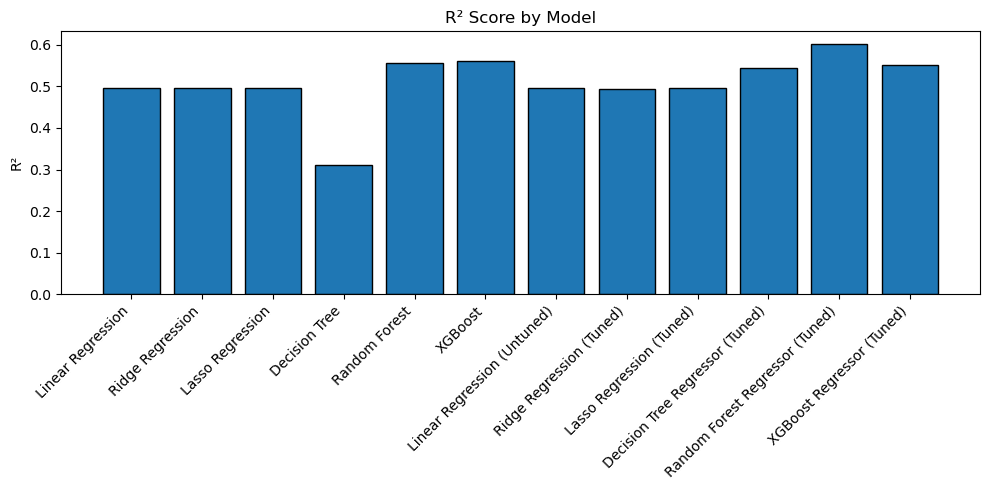

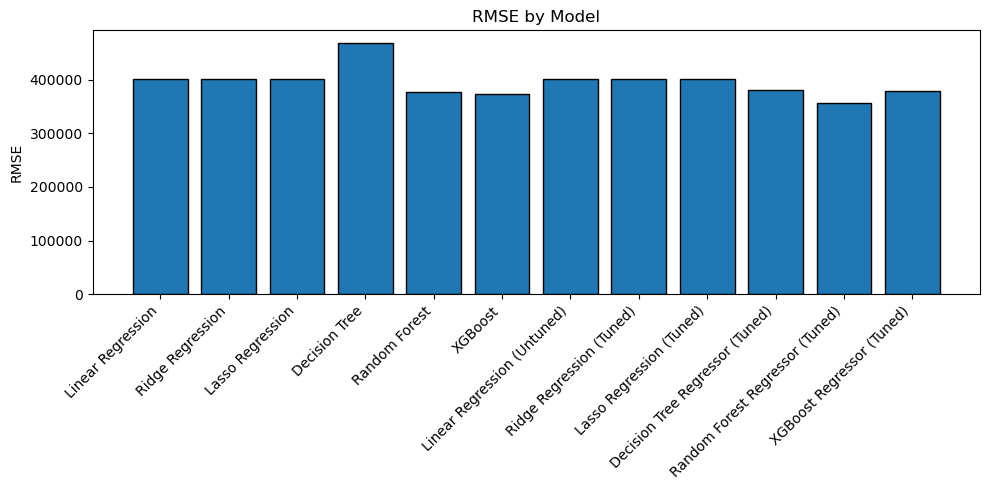

In [20]:
# Plot R²
plt.figure(figsize=(10, 5))
plt.bar(results_df2['Model'], results_df2['R2'], edgecolor='black')
plt.title('R² Score by Model')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
r2_plot_path = "r2_scores_plot.png"
#plt.savefig(r2_plot_path)
#plt.close()

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.bar(results_df2['Model'], results_df2['RMSE'], edgecolor='black')
plt.title('RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
rmse_plot_path = "rmse_scores_plot.png"
#plt.savefig(rmse_plot_path)
#plt.close()

#r2_plot_path, rmse_plot_path, csv_path
plt.show()

### 8 Visualizing and Feature Importances of Random Forest and XGBoost

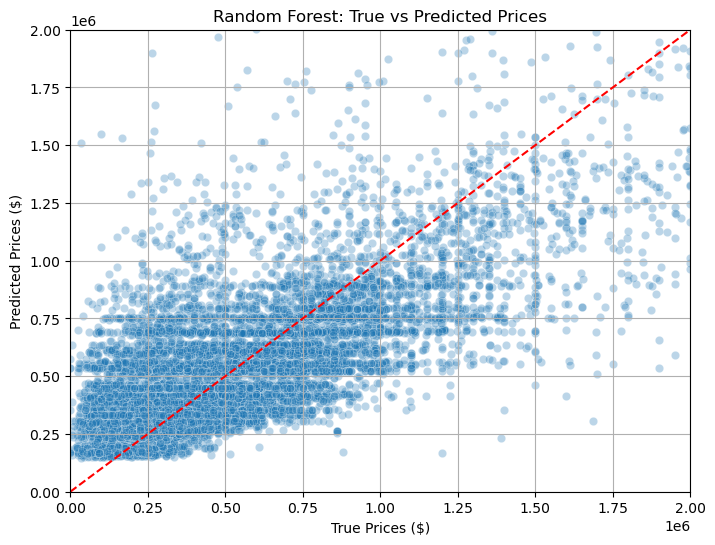

In [22]:
# 8.1 Visualizing predictions for best model (Random Forest)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=rf_grid.predict(X_test), alpha=0.3)
plt.plot([0, 2_000_000], [0, 2_000_000], color='red', linestyle='--')
plt.title("Random Forest: True vs Predicted Prices")
plt.xlabel("True Prices ($)")
plt.ylabel("Predicted Prices ($)")
plt.xlim(0, 2_000_000)
plt.ylim(0, 2_000_000)
plt.grid(True)
plt.show()

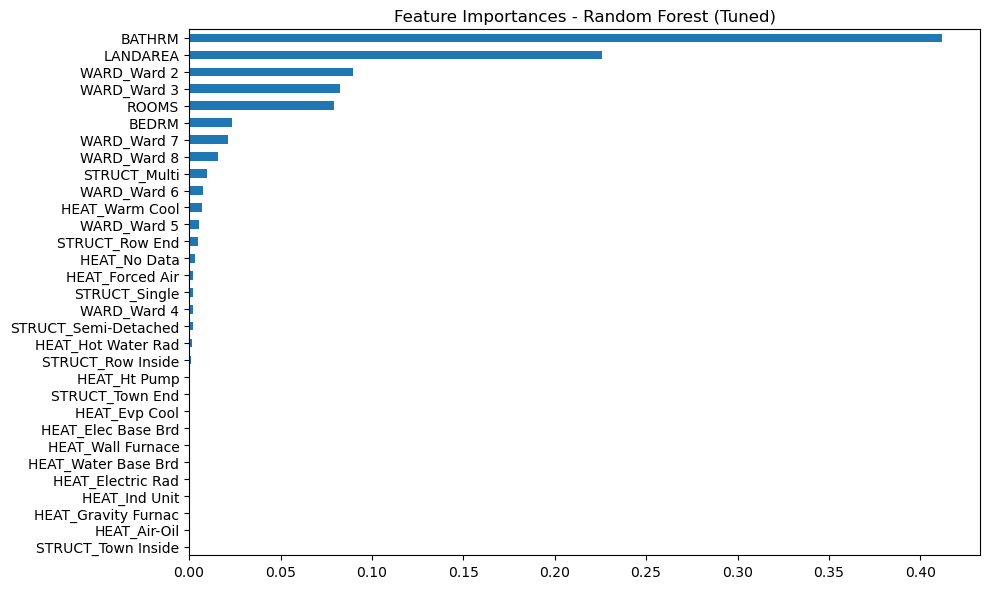

In [23]:
# 8.2 Plot RF importances

# Get the best Random Forest model from GridSearchCV
rf_best = rf_grid.best_estimator_

# Compute Random Forest feature importances
importances_rf = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values()

# Plot Random Forest feature importances
plt.figure(figsize=(10, 6))
importances_rf.plot(kind='barh')
plt.title("Feature Importances - Random Forest (Tuned)")
plt.tight_layout()
#rf_importance_path = "Feature_Importance_RandomForest.png"
#plt.savefig(rf_importance_path)
plt.show()

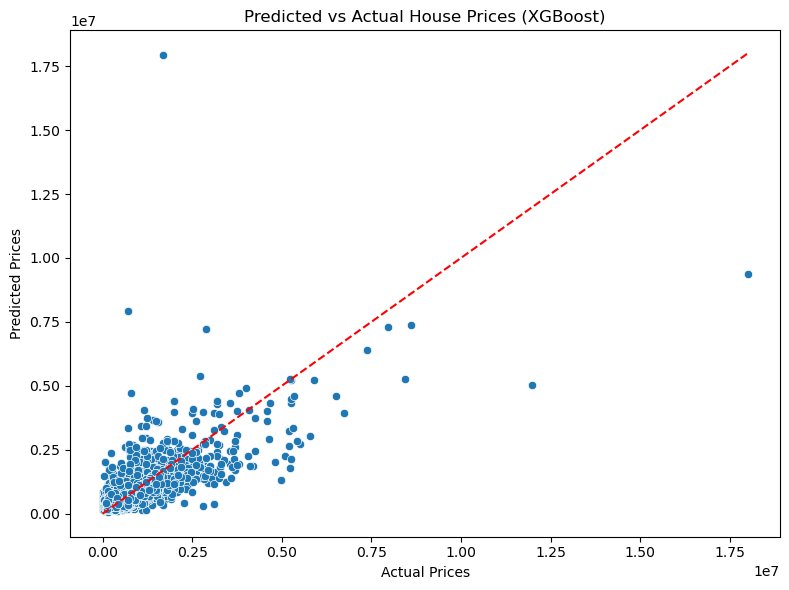

In [24]:
# 8.3 Visualizing XGBoost Predictions (Predicted vs Actual)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=xgb_grid.predict(X_test))
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual House Prices (XGBoost)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

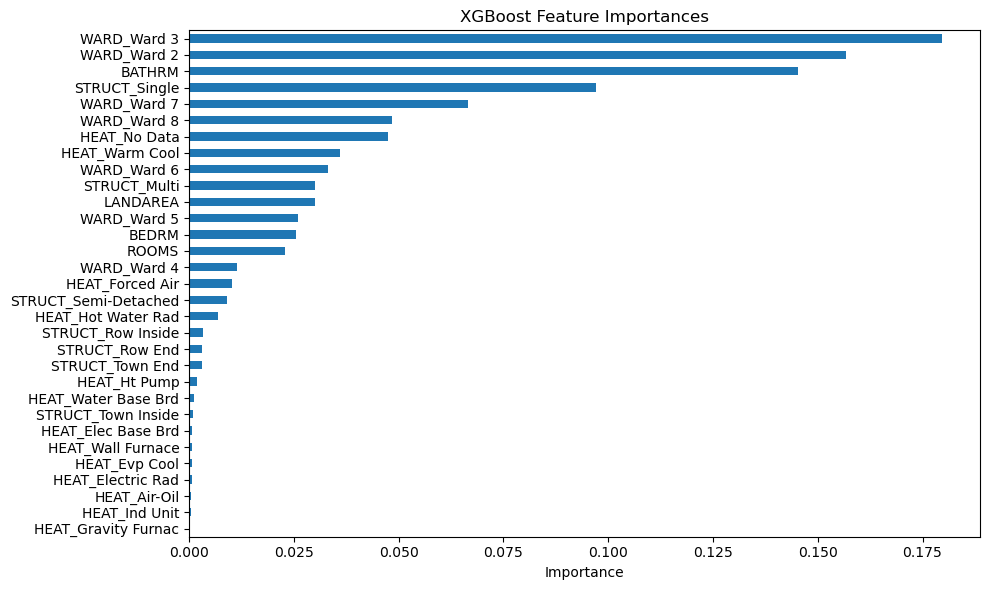

In [25]:
# 8.4 Plot XGBoost importances

# Get the best XGBoost model from GridSearchCV
xgb_best = xgb_grid.best_estimator_

# Compute XGBoost feature importances
importances_xgb = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values()

# Plot XGBoost feature importances
plt.figure(figsize=(10, 6))
importances_xgb.plot(kind='barh')
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
#xgb_importance_path = "Feature_Importance_XGBoost.png"
#plt.savefig(xgb_importance_path)
#plt.close()
plt.show()

### 9 Summary of Modeling Results and Conclusion

#### 9.1 Key Findings from the Model Comparison

##### 9.1.1 Best Overall Model

**Random Forest Regressor** outperforms all others after tunning. It captures the most variance and minimizes prediction errors best:

    - Lowest RMSE: 356,171

    - Highest R²: 0.602

    - Lowest MSE: 1.27 × 10¹¹

##### 9.1.2. Lowest Average Error (MAE)

XGBoost (Untuned) achieves the lowest MAE: 209,933. However, Random Forest overtakes it once tuned.

##### 9.1.3. Effect of Hyperparameter Tuning

- **Random Forest** improves significantly with tuning:

    - RMSE drops from 376,058 → 356,171

    - R² improves from 0.556 → 0.602

- **Decision Tree** also shows clear improvement

- **Linear models** show little or no change after tuning

##### 9.1.4. Linear Models are Limited

All linear models (Linear, Ridge, Lasso) plateau at R² ≈ 0.495. They fail to capture complex, non-linear patterns in housing prices

##### 9.1.5. MAPE Is Less Reliable Alone

MAPE appears lowest for Linear Regression (~4.1%).  But it can be misleading, especially if target values are near zero.

#### 9.2 Final Conclusion

The **Random Forest Regressor** proves to be the most reliable and accurate model in this study. **Tree-based models** significantly outperform linear regressions because they can capture complex relationships effectively. **XGBoost** is also promising, particularly with further tuning. While **linear models** are simple, they are not suitable for this type of data.